In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import QGOpt as qgo
from MERAOpt import MERAOpt
import math

#### Here one generates a random ill-conditioned Hamiltonian with negative definite spectrum.

Text(0, 0.5, '-eigval')

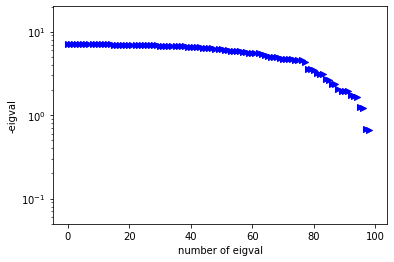

In [28]:
#============================================================#
ham_dim = 100 # dimension of a hamiltonian
renorm_ham_dim = 30 # dimension of a renormalized hamiltonian
#============================================================#

# hamiltonian generation
Q = qgo.manifolds.real_to_complex(tf.random.normal((ham_dim, ham_dim, 2), dtype=tf.float64))
Q, _ = tf.linalg.qr(Q)  # a random unitary matrix (QR decomposition based)

S = tf.random.uniform((ham_dim,), -2, 2)
S = tf.exp(S)
S = tf.cast(S - tf.reduce_max(S), dtype=tf.complex128)  # a random ill-conditioned spectrum

H = tf.einsum('ik,k,jk->ij', Q, S, tf.math.conj(Q))  # a random Hamiltonian

# spectrum plotting
plt.ylim(top=math.exp(3), bottom=math.exp(-3))
plt.scatter(tf.range(0, H.shape[0]), -tf.linalg.eigvalsh(H), color='blue', marker='>')
plt.yscale('log')
plt.xlabel('number of eigval')
plt.ylabel('-eigval')

#### Here one prepares an initial isometric matrix, which is used for renormalization of Hamiltonian, and optimizers to be tested.

In [29]:
# initial random isometric matrix (QR based)
q_in = tf.complex(tf.random.normal((ham_dim, renorm_ham_dim), dtype=tf.float64),
               tf.random.normal((ham_dim, renorm_ham_dim), dtype=tf.float64))
q_in, _ = tf.linalg.qr(q_in)
q_in = qgo.manifolds.complex_to_real(q_in)

# exact minimum value of the quadratic problem
min_value = tf.cast(tf.reduce_sum(tf.linalg.eigvalsh(H)[:renorm_ham_dim]), dtype=tf.float64)


#============================== Different retractions and metrics ===============================#
m_cayley = qgo.manifolds.StiefelManifold(retraction='cayley')
m_svd = qgo.manifolds.StiefelManifold()
m_cayley_canonical = qgo.manifolds.StiefelManifold(retraction='cayley', metric='canonical')
m_svd_canonical = qgo.manifolds.StiefelManifold(metric='canonical')
#================================================================================================#

#==================================== Different optimizers ======================================#
opts = {
        'GD_cayley':qgo.optimizers.RSGD(m_cayley, 0.003),
        'GD_svd':qgo.optimizers.RSGD(m_svd, 0.003),
        'GD_cayley_with_momentum':qgo.optimizers.RSGD(m_cayley, 0.2, 0.9),
        'GD_svd_with_momentum':qgo.optimizers.RSGD(m_svd, 0.2, 0.9),
        'Adam_cayley':qgo.optimizers.RAdam(m_cayley, 0.3),
        'Adam_svd':qgo.optimizers.RAdam(m_svd, 0.3),
        'Adam_cayley_with_ams':qgo.optimizers.RAdam(m_cayley, 0.3, ams=True),
        'Adam_svd_with_ams':qgo.optimizers.RAdam(m_svd, 0.3, ams=True),
        'GD_cayley_canonical':qgo.optimizers.RSGD(m_cayley_canonical, 0.003),
        'GD_svd__canonical':qgo.optimizers.RSGD(m_svd_canonical, 0.003),
        'GD_cayley_with_momentum_canonical':qgo.optimizers.RSGD(m_cayley_canonical, 0.2, 0.9),
        'GD_svd_with_momentum_canonical':qgo.optimizers.RSGD(m_svd_canonical, 0.2, 0.9),
        'Adam_cayley_canonical':qgo.optimizers.RAdam(m_cayley_canonical, 0.3),
        'Adam_svd_canonical':qgo.optimizers.RAdam(m_svd_canonical, 0.3),
        'Adam_cayley_with_ams_canonical':qgo.optimizers.RAdam(m_cayley_canonical, 0.3, ams=True),
        'Adam_svd_with_ams_canonical':qgo.optimizers.RAdam(m_svd, 0.3, ams=True),
        'MERAOpt': MERAOpt()
       }
#================================================================================================#

#### Optimization loop solves the folloving optimization problem $${\rm Tr}\left(V^\dagger H V\right)\rightarrow \min_{V\in \left\{V\in R^{n\times m}|V^\dagger V = I\right\}},$$ by using different types of Riemannian optimizers.

In [30]:
#=============================================#
number_of_steps = 1000  # number of iterations
#=============================================#

err_dict = {} # the disct will be filed by lists of errors vs optimizer

# loop over optimizers
for key, opt in opts.items():
    
    err = [] # will be filled by error vs iter
    q = tf.Variable(q_in) # turning initial isometry to variable
    
    # optimization loop
    for _ in range(number_of_steps):
        with tf.GradientTape() as tape:
            Z = tf.complex(q[..., 0], q[..., 1])  # isometry
            loss = tf.cast(tf.linalg.trace((tf.linalg.adjoint(Z) @ H @ Z)),
                        dtype=tf.float64)  # renormalization and trace
            err.append(loss - min_value)
        grad = tape.gradient(loss, q)  # gradient
        opt.apply_gradients(zip([grad], [q]))  # optimization step

    err_dict[key] = err

#### Plotting the value of error vs iteration for each optimizer.

Text(0, 0.5, 'err')

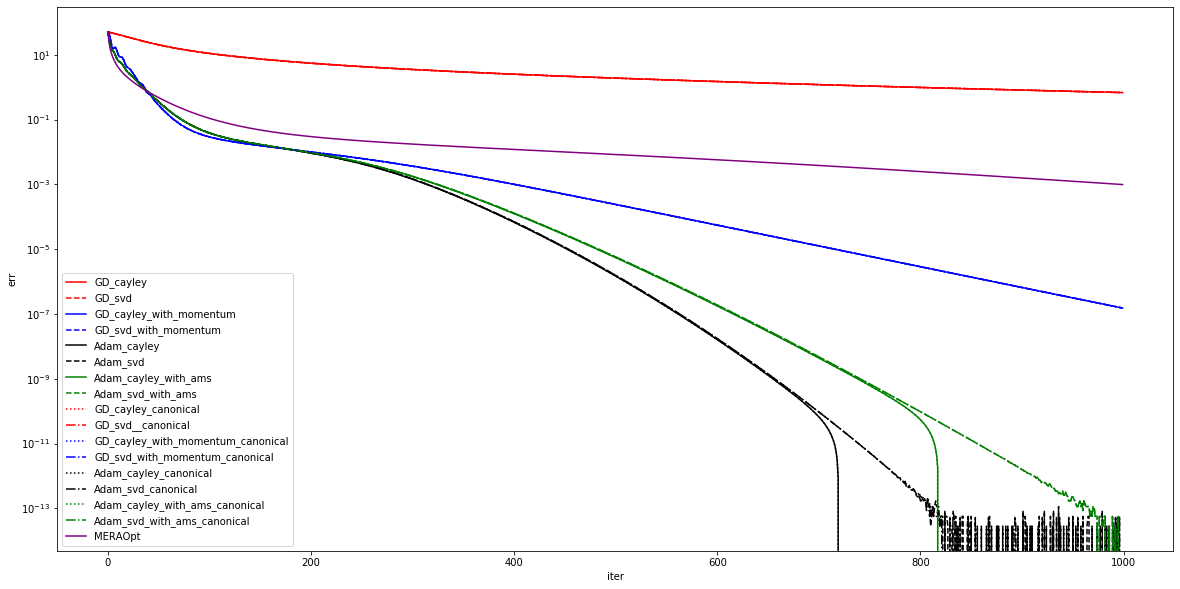

In [31]:
colors = ['r', 'r--', 'b', 'b--', 'k', 'k--', 'g', 'g--', 'r:', 'r-.', 'b:', 'b-.', 'k:', 'k-.', 'g:', 'g-.', 'purple']
plt.figure(figsize=(20, 10))
for i, key in enumerate(opts.keys()):
    plt.plot(err_dict[key], colors[i])
plt.legend(opts.keys())
plt.yscale('log')
plt.xlabel('iter')
plt.ylabel('err')